## <h1><center>Sales Forecasting</center></h1>


In this project I analyse a kaggle time-series dataset consisting of daily sales data from the Russian software firm 1C Company. I implement several state-of-the-art techniques in order to forecast the future profits of the company.  

In [0]:
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import warnings

from forecasting_functions import *

%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')



> First, the dataset is loaded into a pandas dataframe, using the date as the index. The dataset contains every individual sell therefore, in order to use the date as a real index, the data will need to be resampled. 



In [229]:
sales = pd.read_csv('/content/drive/My Drive/sales_train.csv', index_col='date', parse_dates=True)
item_cat=pd.read_csv("/content/drive/My Drive/item_categories.csv")
item=pd.read_csv("/content/drive/My Drive/items.csv")
shops=pd.read_csv("/content/drive/My Drive/shops.csv")
sales.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0
2013-10-01,0,25,2564,349.00,1.0
2013-02-01,0,25,2565,549.00,1.0
2013-04-01,0,25,2572,239.00,1.0
2013-11-01,0,25,2572,299.00,1.0


In [230]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [231]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [232]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


> I will only use the sales dataset for this project.

---

> We can begin by calculating the profits of the company.

> The profit made from every individual entry in the dataframe can be calculated by multiplying the item price and the number of items sold.  



In [54]:
sales['profit'] = sales['item_price'] * sales['item_cnt_day']
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,profit
date,,,,,,
2013-02-01,0,59,22154,999.00,1.0,999.00
2013-03-01,0,25,2552,899.00,1.0,899.00
2013-05-01,0,25,2552,899.00,-1.0,-899.00
2013-06-01,0,25,2554,1709.05,1.0,1709.05
2013-01-15,0,25,2555,1099.00,1.0,1099.00




> Now, the monthly profit can be calculated and displayed.



Text(0, 0.5, 'Sales')

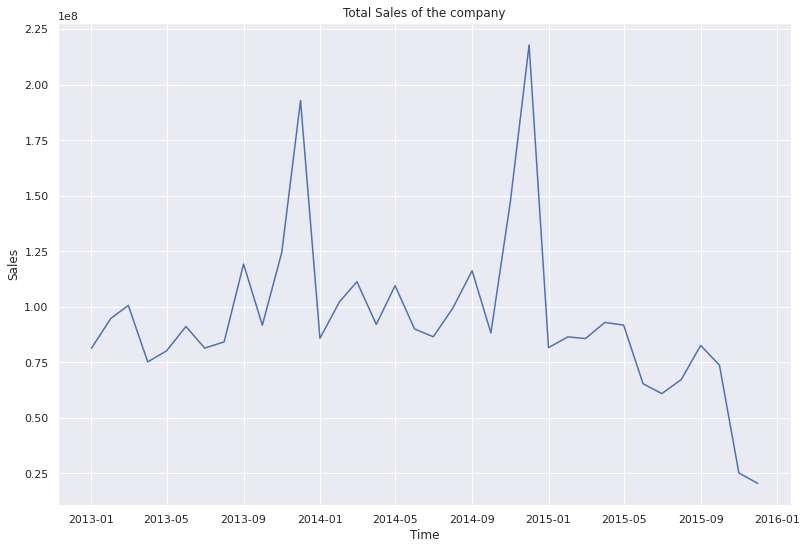

In [55]:
monthly_sales = sales['profit'].resample('MS').sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(style="event",
             data=monthly_sales,)
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')

> There is a clear seasonal effect in the data, as well as a negative trend or constant term. Furthermore, there seems to be a change in the seasonal effect by the end as towards the end of 2015 profits are going down despite the fact that profits increased in the period in the previous years. We can analyse this further using seasonal decomposition on the data.



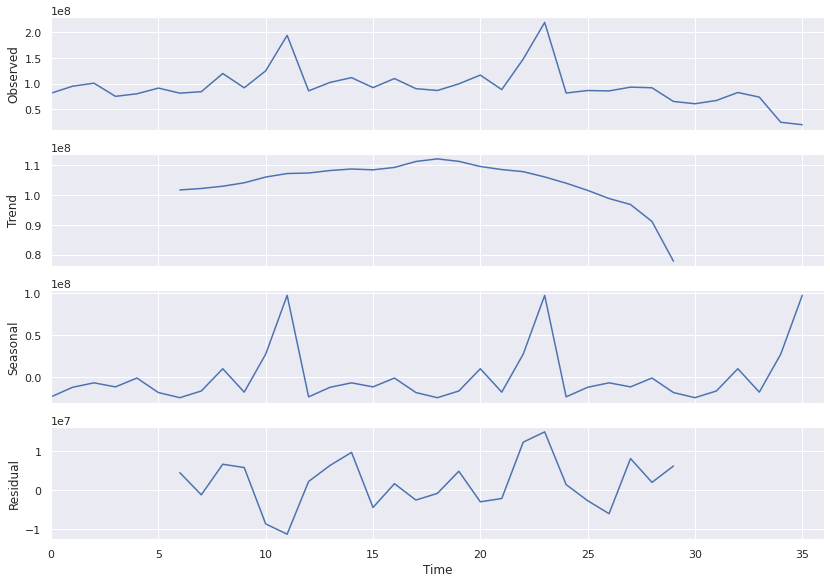

In [56]:
decomposition = sm.tsa.seasonal_decompose(monthly_sales.values,freq=12, model='additive')
seasonal_plot = decomposition.plot()



> After seeing the decomposition, the Augmented Dickey-Fuller test can be used to determine if the series is stationary. Given the shape of the trend component, I am going to assume a drift term and a quadratic trend.



In [57]:
def test_stationarity(timeseries):
    
    #Perform Augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, regression='ctt', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(monthly_sales)

Results of Dickey-Fuller Test:
Test Statistic                 -4.969263
p-value                         0.001158
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -4.739253
Critical Value (5%)            -4.014079
Critical Value (10%)           -3.663623
dtype: float64




> The series is certainly stationary under the assumtion of a drift term and a quadratic trend, with a probability of 99.9%. We can now plot the autocorrelation and partial autocorrelation functions in order to gain a better understanding of the data.



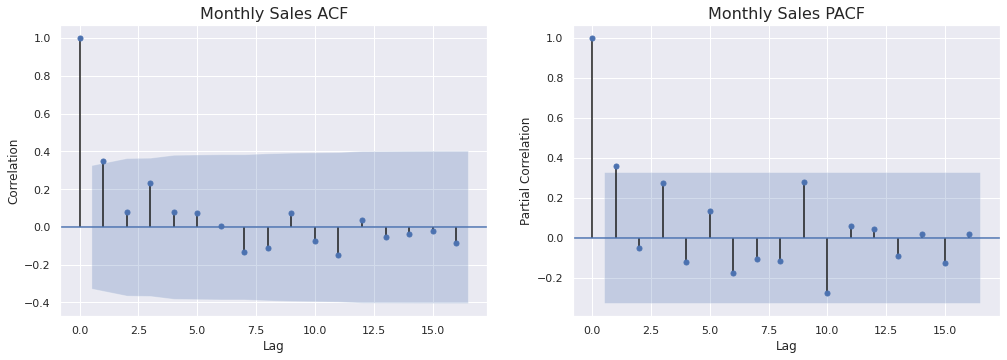

In [58]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
plot_acf(monthly_sales,ax=axs[0],)
plot_pacf(monthly_sales,ax=axs[1])
axs[0].set_title('Monthly Sales ACF',fontsize=16)
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Correlation')
axs[1].set_title('Monthly Sales PACF',fontsize=16)
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Correlation')
plt.show()



> As can be seen, the only significant autocorrelation and partial autocorrelation is at lag 1, and even these values could be false positives as they barely escape the 95% confidence intervals. 



> Another impotant detail to notice is that there is no significant autocorrelation around lag 12, which would have been expected given the clear seasonal effect. The explanation for this finding could lie in the drastic change in trend towards the end of the available datal which goes against the observed seasonal effect. 



> If the last few months of data would be removed, there should be autocorrelations or partial autocorrelations around lag 12.








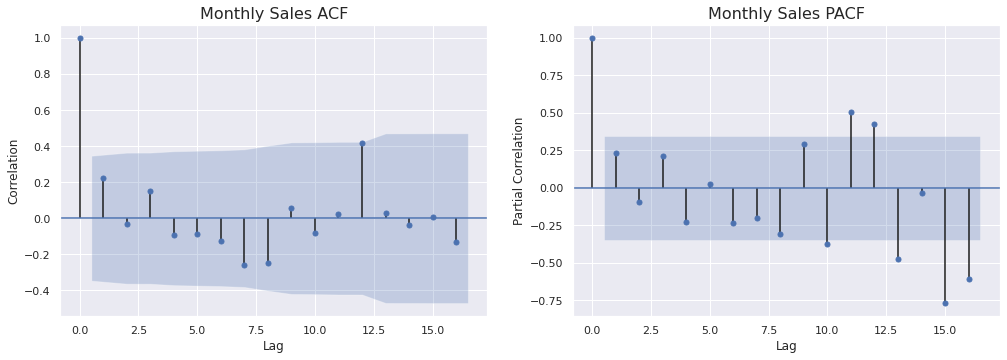

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
plot_acf(monthly_sales[:'2015-08-01'],ax=axs[0])
plot_pacf(monthly_sales[:'2015-08-01'],ax=axs[1])
axs[0].set_title('Monthly Sales ACF',fontsize=16)
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Correlation')
axs[1].set_title('Monthly Sales PACF',fontsize=16)
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Correlation')
plt.show()



> As expected, with the last few months removed, there is significant partial autocorrelation at lag 12. Furthermore, there is significant partial autocorrelation at almost every lag value after 10, suggesting a very pronounced cyclical effect in the first two years. 


> After analysing the time series, the next step is to develop a baseline forecasting model. The following code uses the functions from forecasting_functions.py; the functions are credited to Jason Brownlee and can be found in his book 'Deep Learning for Time Series Forecasting'. I have made several changes to the functions to adapt them to the current task however, the idea behind them is the same as in the aforementioned book: run several models on intervals of the series, use them to forecast the next value after the interval used for training, calculate the root mean square error between the forecast and the actual value and choose the model with the best RMSE. 







In [60]:
n_test = 24
# model configs
max_length = len(monthly_sales) - n_test
offsets = list(range(11,14))
offsets.append(1)
cfg_list = simple_configs(max_length, offsets)
# grid search
scores = grid_search(monthly_sales, cfg_list, n_test, simple_forecast)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[1, 11, 'persist']] 43145889.720
 > Model[[1, 12, 'persist']] 43145889.720
 > Model[[1, 13, 'persist']] 43145889.720
 > Model[[1, 1, 'persist']] 43145889.720
 > Model[[2, 11, 'persist']] 49954737.638
 > Model[[2, 12, 'persist']] 49954737.638
 > Model[[2, 13, 'persist']] 49954737.638
 > Model[[2, 1, 'persist']] 49954737.638
 > Model[[2, 1, 'mean']] 40799284.229
 > Model[[2, 1, 'median']] 40799284.229
 > Model[[3, 11, 'persist']] 45945623.493
 > Model[[3, 12, 'persist']] 45945623.493
 > Model[[3, 13, 'persist']] 45945623.493
 > Model[[3, 1, 'persist']] 45945623.493
 > Model[[3, 1, 'mean']] 37331185.095
 > Model[[3, 1, 'median']] 36163365.517
 > Model[[4, 11, 'persist']] 48620122.897
 > Model[[4, 12, 'persist']] 48620122.897
 > Model[[4, 13, 'persist']] 48620122.897
 > Model[[4, 1, 'persist']] 48620122.897
 > Model[[4, 1, 'mean']] 36735970.712
 > Model[[4, 1, 'median']] 34503093.103
 > Model[[5, 11, 'persist']] 48143436.120
 > Model[[5, 12, 'persist']] 48143436.120
 > Model[[5, 1



> The simple forecast function ran several persistence and average models in order to fit the last 24 months of data. The model with the lowest RMSE used the median of the last 7 values to forecast future profits: 

\begin{align}
x_t & = med(x_{t-1},x_{t-2},x_{t-3},x_{t-4},x_{t-5},x_{t-6},x_{t-7})
\end{align}



> I will now plot the forecast alongside the data using a function I made which can also be found in the forecasting_functions.py file









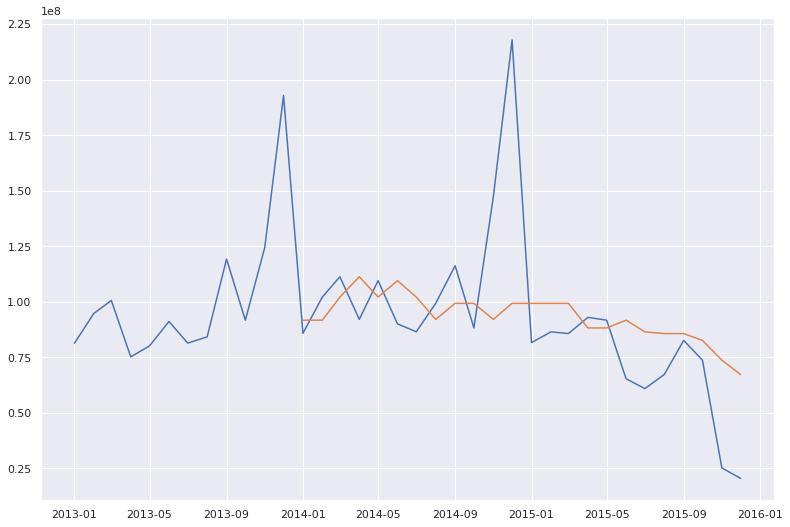

In [61]:
config = (7,1,'median')
pred = plot_forecast(monthly_sales,24,config,simple_forecast)



> While the forecast follows the data somewhat closely, it does not account for the seasonal effect. We can attempt to improve on this baseline model using exponential smoothing models.



In [67]:
# data split
n_test = 24
# model configs
cfg_list = exp_smoothing_configs(seasonal=[None,12])
# grid search
scores = grid_search(monthly_sales, cfg_list, n_test, exp_smoothing_forecast)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[['add', True, None, 12, False, True]] 43010914.459
 > Model[['add', True, None, 12, False, False]] 43902644.893
 > Model[['add', False, None, 12, False, True]] 43052771.147
 > Model[['add', False, None, 12, False, False]] 44064382.705
 > Model[['mul', True, None, 12, False, True]] 61323682.768
 > Model[['mul', True, None, 12, False, False]] 139383668.027
 > Model[['mul', False, None, 12, False, True]] 44623869.625
 > Model[['mul', False, None, 12, False, False]] 45049253.634
 > Model[[None, False, 'add', 12, False, True]] 33261626.627
 > Model[[None, False, 'add', 12, False, False]] 33740362.777
 > Model[[None, False, 'mul', 12, False, True]] 26635322.824
 > Model[[None, False, 'mul', 12, False, False]] 27038283.996
 > Model[[None, False, None, 12, False, True]] 45550483.972
 > Model[[None, False, None, 12, False, False]] 43381081.706
done
[None, False, 'mul', 12, False, True] 26635322.823520716
[None, False, 'mul', 12, False, False] 27038283.99590964
[None, False, 'add', 12, 



> The best exponential smoothing model has achieved better forecasting results than the baseline methods. The configurations indicate the best fit is a model with no trend component, no damping, a multiplicative seasonal yearly trend, no box-cox transform and removing bias by enforcing that the average residual equals 0. Thus, the current model can be represented using the following set of equations:

\begin{align}
x_{t+1} & = l_t \cdot s_{(t+1)-12} \\
l_t & = \alpha \frac{x_t}{s_{t-12}} + (1-\alpha)l_{t-1} \\
s_t & = \gamma \frac{x_t}{l_{t-1}} + (1-\gamma)s_{t-12}
\end{align}


> Where the first equation is the forecasting equation, the second is the level equation and the third is the seasonal equation. Alpha and Gamma represent the smoothing coefficient for the level and seasonal equation, respectively. 





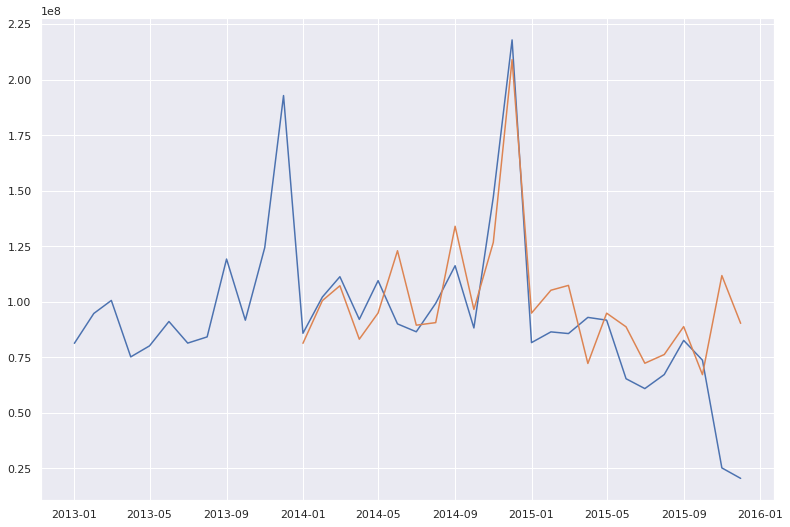

In [70]:
config = [None, False, 'mul', 12, False, True]
pred = plot_forecast(monthly_sales,24,config, exp_smoothing_forecast)



> As can be seen, the model clearly performed significantly better than the baseline methods.


> The next models to try are the SARIMA models. Due to the larger hyperparameter space the search process will be implemented differently here.


> First, I define the list of configurations. Given the observations from the ACF and PACF I decided to include AR and MA orders up to 11. I am also checking for integration order up to 2 as we have observed as seemingly quadratic trend in the seasonal decomposition. For seasonality, I will only check 0 and 1 terms. 



In [0]:
pdq = list()
seasonal_pdq = list()
p_params = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
P_params = [0, 1]
D_params = [0, 1]
Q_params = [0, 1]
for p in p_params:
  for d in d_params:
    for q in q_params:
      pdq.append((p,d,q))
for P in P_params:
  for D in D_params:
    for Q in Q_params: 
      seasonal_pdq.append((P,D,Q,12))
t_params = ['n','c','t','ct']



> With the configurations defined, I will now train models using all of these configurations and measure the RMSE for the whole dataset as well as the Akaike Information Criteria (AIC).



In [0]:
all_results = list()
for param in pdq:
  for param_seasonal in seasonal_pdq:
    for param_trend in t_params:
      try:
        mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        trend=param_trend,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        rmse=measure_rmse(results.get_prediction(dynamic=False).predicted_mean,monthly_sales)
        all_results.append([param, param_seasonal,param_trend,rmse,results.aic])
        print('ARIMA{}x{} {} trend - RMSE:{} - AIC:{}'.format(param, param_seasonal, param_trend, rmse,results.aic))
            
      except:
        continue

In [123]:
all_results = pd.DataFrame(all_results, columns=['ARIMA', 'Seasonal', 'Trend', 'RMSE', 'AIC'])
all_results.head()

,ARIMA,Seasonal,Trend,RMSE,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",n,1.008746e+08,1391.732483
1,"(0, 0, 0)","(0, 0, 0, 12)",c,3.795631e+07,1321.180119
2,"(0, 0, 0)","(0, 0, 0, 12)",t,6.603200e+07,1363.220091
3,"(0, 0, 0)","(0, 0, 0, 12)",ct,3.644985e+07,1319.900947
4,"(0, 0, 0)","(0, 1, 0, 12)",n,7.391475e+07,886.952989




> I will now simply choose the model with the lowest overall RMSE. 



In [202]:
best_model = all_results.loc[all_results['RMSE']==min(all_results.loc[all_results['AIC']<600]['RMSE'])]
best_model

,ARIMA,Seasonal,Trend,RMSE,AIC
3460,"(9, 1, 6)","(1, 0, 0, 12)",n,2.946767e+07,545.320407


In [203]:
mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                order=best_model.values[0][0],
                                seasonal_order=best_model.values[0][1],
                                trend=best_model.values[0][2],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1243      5.295      0.023      0.981     -10.253      10.502
ar.L2         -0.3156      8.446     -0.037      0.970     -16.869      16.238
ar.L3         -0.1409      7.641     -0.018      0.985     -15.116      14.834
ar.L4          0.7357      6.825      0.108      0.914     -12.641      14.112
ar.L5         -0.3846      2.789     -0.138      0.890      -5.851       5.082
ar.L6          0.6135      7.033      0.087      0.930     -13.172      14.399
ar.L7         -0.0393      8.924     -0.004      0.996     -17.530      17.451
ar.L8         -0.0954     13.424     -0.007      0.994     -26.407      26.216
ar.L9         -0.1437      3.443     -0.042      0.967      -6.892       6.605
ma.L1          1.1121      3.436      0.324      0.746      -5.623       7.847
ma.L2         -1.4511     11.769     -0.123      0.9

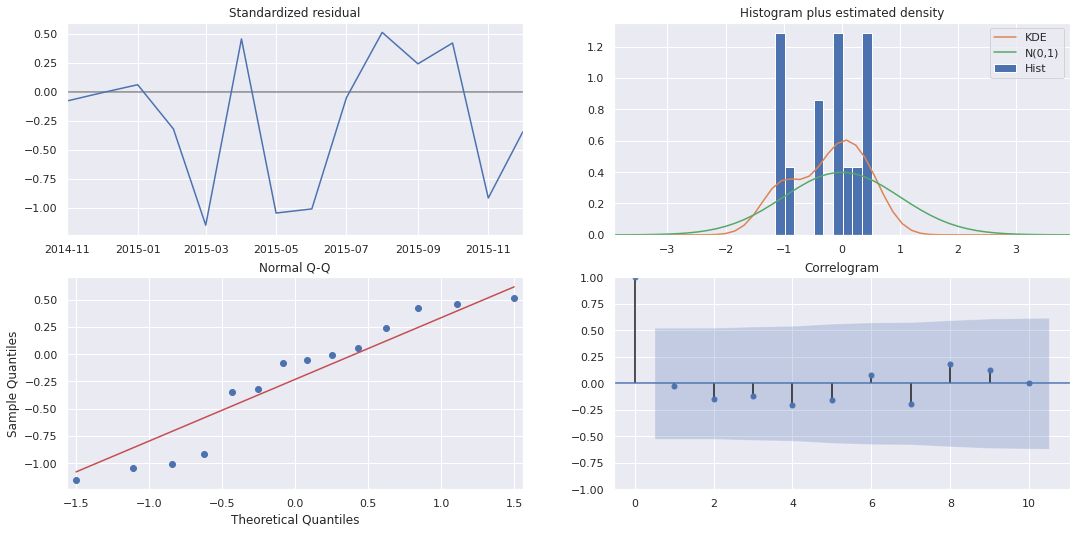

In [210]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()



> None of the terms included in the model are significant and the residuals do not seem to follow a normal distribution however, they also do not show any autocorrelation. 

> We can visualize the model compared to the time series. 



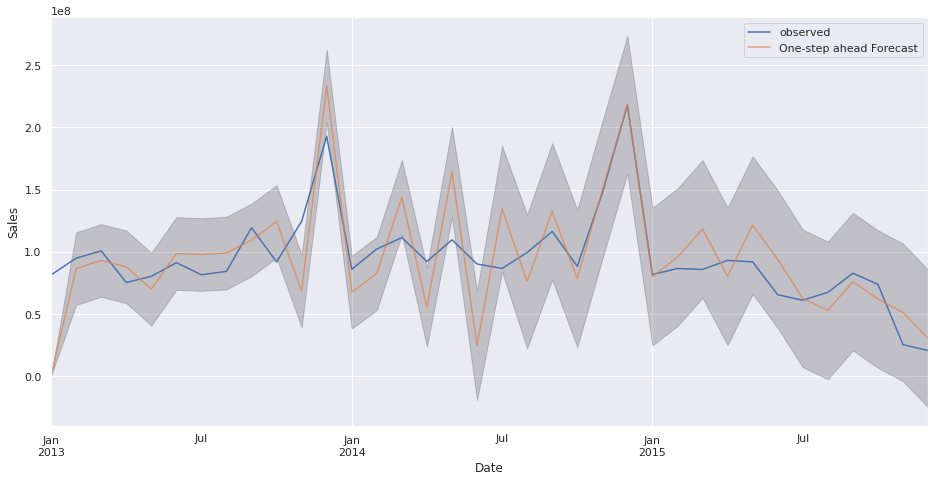

In [190]:
pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
ax = monthly_sales.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [208]:
rmse = measure_rmse(monthly_sales['2014-01-01':],
             results.get_prediction(start=pd.to_datetime('2014-01-01'), 
                                    dynamic=False).predicted_mean)
print(f"Sarima model RMSE for sales after 2014: {round(rmse,2)}")

Sarima model RMSE for sales after 2014: 27214024.84




> This model overemphasizes the cyclical effects in the time series. Furthermore, it's one-step forecasts for the last two thirds of the data are worse than the forecasts of the previous eponential smoothing model. 



> Overall, it is not a very strong model. We can also check how its forecasts for the future look like.


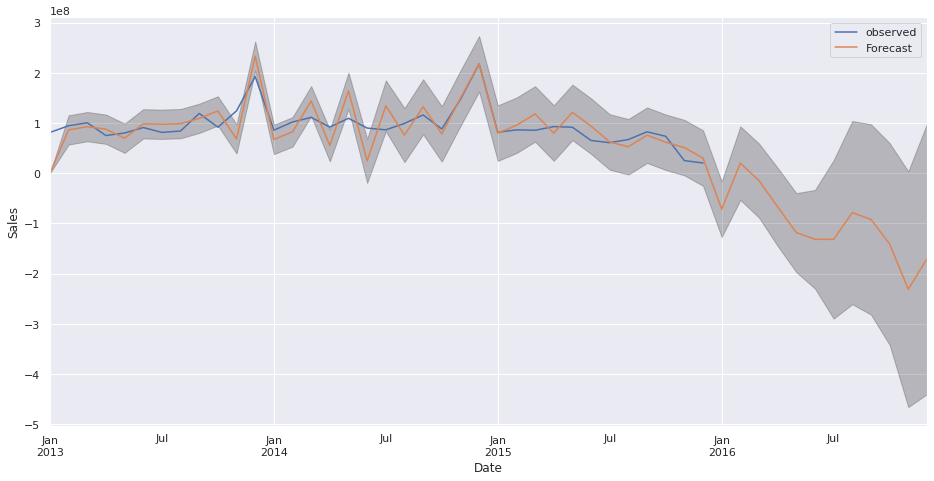

In [209]:
pred_uc = results.get_forecast(steps=12)
forecast_frames = [pred.predicted_mean, pred_uc.predicted_mean]
ci_frames = [pred.conf_int(), pred_uc.conf_int()]
forecast = pd.concat(forecast_frames) 
forecast_ci = pd.concat(ci_frames)
ax = monthly_sales.plot(label='observed', figsize=(14, 7))
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()


> While the models are only evaluated on their ability to do one step forecasts and their long term forecasts are not expected to be great, this model has very unrealistic forecasts and extremely large confidence intervals, making it very unlikely to be a useful model for this task. 



---

> One final approach for this task that I would like to try is using Facebook's Prophet library for time series forecasting. 





INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

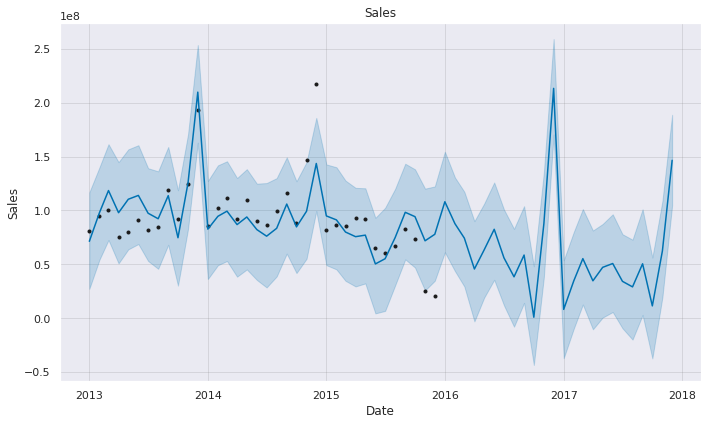

In [211]:
from fbprophet import Prophet
monthly_sales = pd.DataFrame(monthly_sales)
p_sales = monthly_sales.rename(columns={'profit': 'y'})
p_sales['ds']=p_sales.index

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(p_sales)

prophet_forecast = prophet_model.make_future_dataframe(periods=24, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

plt.figure(figsize=(18, 6))
prophet_model.plot(prophet_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales');



> The forecast looks very promising; let's also analyse its RMSE between 2014 and 2016 to see how it fares against the previous models.  



In [220]:
prophet_forecast = prophet_forecast.set_index(prophet_forecast.ds)
rmse = measure_rmse(monthly_sales['2014-01-01':],prophet_forecast['2014-01-01':'2015-12-01']['yhat'])
print(f'Prophet model RMSE for sales after 2014: {round(rmse,2)}') 

Prophet model RMSE for sales after 2014: 25836232.9




> It appears that this model has achieved better results than all previous models. Thus, it will be the final model for this task.

> We can take a look at its trend and seasonal components.



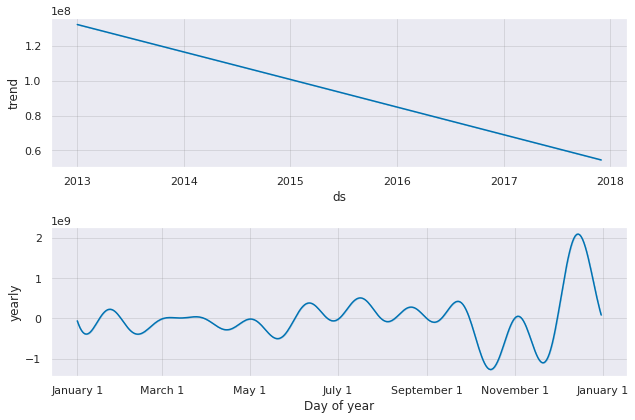

In [0]:
prophet_model.plot_components(prophet_forecast)
plt.show()



> This model found a negative linear trend and a seasonal effect towards the end of the year, which is mostly what we would expect from the plot of the time series and its ACF and PACF. 



In [227]:
import plotly.io as pio
from fbprophet.plot import plot_plotly
import plotly.offline as py

pio.renderers.default = "colab"
fig = plot_plotly(prophet_model, prophet_forecast) 
py.iplot(fig)

> With these results, we can now move forward and apply the model to the individual shops in the company. 

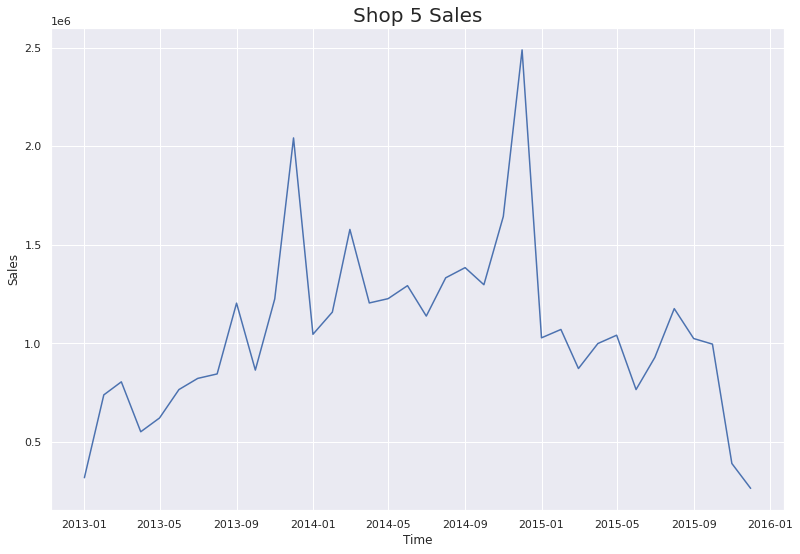

In [224]:
shop_id=5
shop_sales=sales.loc[sales['shop_id']==shop_id]
shop_sales=shop_sales["profit"].resample('MS').sum()
shop_sales.astype('float')
plt.title('Shop 5 Sales',fontsize=20)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(shop_sales)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

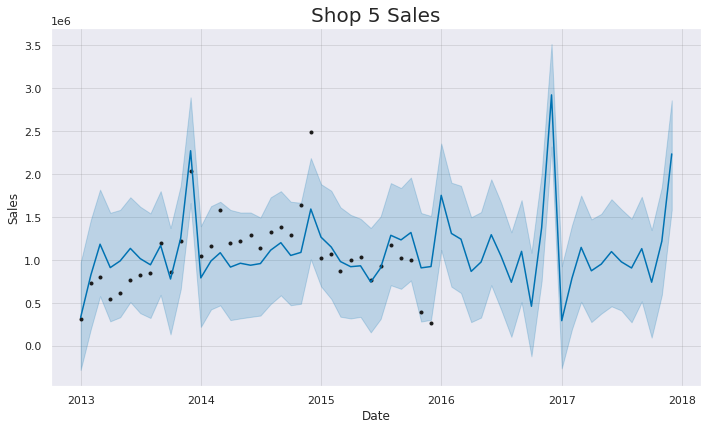

In [225]:
shop_sales = pd.DataFrame(shop_sales)
shop_sales = shop_sales.rename(columns={'profit': 'y'})
shop_sales['ds']=shop_sales.index

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(shop_sales)

prophet_forecast = prophet_model.make_future_dataframe(periods=24, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

plt.figure(figsize=(18, 6))
prophet_model.plot(prophet_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Shop 5 Sales', fontsize=20);



> I will now forecast the future sales of every shop with at least two years of sales data and save the results in the form of an interactive plotly html file. 



In [0]:
for shop_id in range(0,60):
  shop_sales=sales.loc[sales['shop_id']==shop_id]
  shop_sales=pd.DataFrame(shop_sales["profit"].resample('MS').sum())
  if len(shop_sales)>=24:     #if the shop has at least two years of sales data
    shop_sales = shop_sales.rename(columns={'profit': 'y'})
    shop_sales['ds']=shop_sales.index

    prophet_model = Prophet(interval_width=0.95)
    prophet_model.fit(shop_sales)

    prophet_forecast = prophet_model.make_future_dataframe(periods=12, freq='MS')
    prophet_forecast = prophet_model.predict(prophet_forecast)

    fig = plot_plotly(prophet_model, prophet_forecast)
    fig.write_html(f"/content/drive/My Drive/sales_plots/shop{shop_id}_sales.html")

> By the end of this project, I have succesfully built a series of forecasting models to predict the future profits of the company at large as well as the majority of the shops that are part of the company; furthermore I have gained a good understanding of the sales history of the company. 